# 1. Importing the dependencies

In [2]:
import torch
from torch import nn
import os
from pathlib import Path

torch.__version__

'2.8.0+cu128'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 2. Getting the data

In [4]:
data_path = Path("D:/Codes/Pycharm Projects/PYTORCH/PROJECTS/DEEP-LEARNING/Data")
img_path = data_path / "pizza_steak_sushi"

In [5]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'...")

walk_through_dir(img_path)


There are 2 directories and 0 images in 'D:\Codes\Pycharm Projects\PYTORCH\PROJECTS\DEEP-LEARNING\Data\pizza_steak_sushi'...
There are 3 directories and 0 images in 'D:\Codes\Pycharm Projects\PYTORCH\PROJECTS\DEEP-LEARNING\Data\pizza_steak_sushi\test'...
There are 0 directories and 25 images in 'D:\Codes\Pycharm Projects\PYTORCH\PROJECTS\DEEP-LEARNING\Data\pizza_steak_sushi\test\pizza'...
There are 0 directories and 19 images in 'D:\Codes\Pycharm Projects\PYTORCH\PROJECTS\DEEP-LEARNING\Data\pizza_steak_sushi\test\steak'...
There are 0 directories and 31 images in 'D:\Codes\Pycharm Projects\PYTORCH\PROJECTS\DEEP-LEARNING\Data\pizza_steak_sushi\test\sushi'...
There are 3 directories and 0 images in 'D:\Codes\Pycharm Projects\PYTORCH\PROJECTS\DEEP-LEARNING\Data\pizza_steak_sushi\train'...
There are 0 directories and 78 images in 'D:\Codes\Pycharm Projects\PYTORCH\PROJECTS\DEEP-LEARNING\Data\pizza_steak_sushi\train\pizza'...
There are 0 directories and 75 images in 'D:\Codes\Pycharm Projec

In [6]:
train_dir = img_path / "train"
test_dir = img_path / "test"

train_dir, test_dir

(WindowsPath('D:/Codes/Pycharm Projects/PYTORCH/PROJECTS/DEEP-LEARNING/Data/pizza_steak_sushi/train'),
 WindowsPath('D:/Codes/Pycharm Projects/PYTORCH/PROJECTS/DEEP-LEARNING/Data/pizza_steak_sushi/test'))

# 3. Visualizing the image

Random image path : D:\Codes\Pycharm Projects\PYTORCH\PROJECTS\DEEP-LEARNING\Data\pizza_steak_sushi\test\sushi\2394442.jpg
Image_class : sushi
Image height : 408
Image width : 512


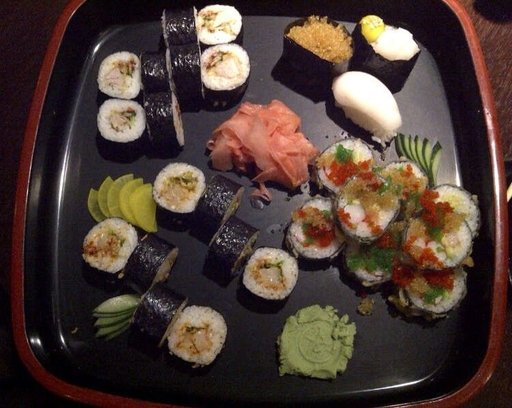

In [7]:
import random
from PIL import Image

random.seed(42)

img_path_list = list(img_path.glob("*/*/*.jpg"))
random_image_path = random.choice(img_path_list)
image_class =random_image_path.parent.stem

image =Image.open(str(random_image_path))

print(f"Random image path : {random_image_path}")
print(f"Image_class : {image_class}")
print(f"Image height : {image.height}")
print(f"Image width : {image.width}")
image

# 4. MODEL 0 : TinyVGG without DATA AUGMENTATION

In [8]:
import torchvision
import os
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from typing import Tuple, Dict, List

### 4.1 Creating transform for MODEL 0

In [9]:
simple_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [10]:
train_data_simple = datasets.ImageFolder(root = train_dir, transform = simple_transform)
test_data_simple = datasets.ImageFolder(root = test_dir, transform = simple_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset = train_data_simple, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = True)
test_dataloader_simple = DataLoader(dataset = test_data_simple, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = False)

In [11]:
target_directory = train_dir
print(f"Target directory : {target_directory}")

class_names_found =sorted([entry.name for entry in os.scandir(target_directory)])
class_names_found

Target directory : D:\Codes\Pycharm Projects\PYTORCH\PROJECTS\DEEP-LEARNING\Data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [12]:
def find_classes(directory : str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    class_to_idx ={class_name : i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [13]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 4.2 Creating the TinyVGG Model

In [14]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape : int, hidden_units : int, output_shape : int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*28*28, out_features = output_shape),
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x)
        x = self.conv_block_2(x)
#         print(x)
        x = self.conv_block_3(x)
#         print(x)
        x = self.classifier(x)
        return x

In [15]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3, hidden_units = 10, output_shape = len(class_names_found)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fea

### 4.3 Creating TRAIN Loops and TEST Loops

In [16]:
def train_step(model : torch.nn.Module, dataloader : torch.utils.data.DataLoader, loss_fn : torch.nn.Module, optimizer :  torch.optim.Optimizer, device : device):
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y  = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss, train_acc

def test_step(model : torch.nn.Module, dataloader : torch.utils.data.DataLoader, loss_fn : torch.nn.Module, device : device):
    model.eval()

    test_loss, test_acc = 0,0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim = 1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 4.4 Creating the `train()` function

In [17]:
from tqdm.auto import tqdm

def train(model : torch.nn.Module, train_dataloader, test_dataloader, loss_fn : torch.nn.Module, optimizer : torch.optim.Optimizer,epochs , device : device):

    results = {"train_loss" : [], "train_acc" : [], "test_loss" : [], "test_acc" : []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model, dataloader = train_dataloader, loss_fn =  loss_fn, optimizer =  optimizer, device = device)
        test_loss, test_acc = test_step(model = model, dataloader = test_dataloader, loss_fn = loss_fn, device = device)

        print(f"Epoch : {epoch} | Train loss : {train_loss:.4f} | Train acc : {train_acc : .4f} | Test loss : {test_loss:.4f} | Test acc : {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

### 4.5 Train and evaluate model_0

In [18]:
NUM_EPOCHS = 30

model_0 =TinyVGG(input_shape = 3, hidden_units = 10, output_shape = len(train_data_simple.classes)).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.01)

from timeit import default_timer as timer
start_time = timer()

model_0_results =train(model = model_0, train_dataloader = train_dataloader_simple, test_dataloader =  test_dataloader_simple, loss_fn = loss_fn, optimizer = optimizer, epochs = NUM_EPOCHS, device = device)

end_time = timer()

print(f"Total training time : {end_time - start_time : .3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch : 0 | Train loss : 1.2584 | Train acc :  0.2578 | Test loss : 1.0972 | Test acc : 0.1979
Epoch : 1 | Train loss : 1.0956 | Train acc :  0.4141 | Test loss : 1.1045 | Test acc : 0.1979
Epoch : 2 | Train loss : 1.1027 | Train acc :  0.2930 | Test loss : 1.1104 | Test acc : 0.1979
Epoch : 3 | Train loss : 1.0930 | Train acc :  0.4141 | Test loss : 1.1079 | Test acc : 0.1979
Epoch : 4 | Train loss : 1.0918 | Train acc :  0.4141 | Test loss : 1.1114 | Test acc : 0.1979
Epoch : 5 | Train loss : 1.0903 | Train acc :  0.4141 | Test loss : 1.1174 | Test acc : 0.1979
Epoch : 6 | Train loss : 1.0885 | Train acc :  0.4141 | Test loss : 1.1230 | Test acc : 0.1979
Epoch : 7 | Train loss : 1.1103 | Train acc :  0.2930 | Test loss : 1.1279 | Test acc : 0.1979
Epoch : 8 | Train loss : 1.1083 | Train acc :  0.2930 | Test loss : 1.1205 | Test acc : 0.1979
Epoch : 9 | Train loss : 1.1044 | Train acc :  0.2930 | Test loss : 1.1105 | Test acc : 0.1979
Epoch : 10 | Train loss : 1.1005 | Train acc :  0.

# 5. MODEL 1 : TinyVGG with DATA AUGMENTATION

In [19]:
from torchvision import transforms

train_transform_trivial = transforms.Compose([transforms.Resize(size = (224, 224)), transforms.TrivialAugmentWide(num_magnitude_bins = 31), transforms.ToTensor()])
test_transform_trivial = transforms.Compose([transforms.Resize(size = (224, 224)), transforms.ToTensor()])

### 5.1 Creating train and test `Dataset's` and `Dataloader's` with **DATA AUGMENTATION**

In [20]:
from torchvision import datasets

train_data_augmented =datasets.ImageFolder(root = train_dir, transform = train_transform_trivial)
test_data_augmented = datasets.ImageFolder(root = test_dir, transform = test_transform_trivial)

In [21]:
import os
from torch.utils.data import DataLoader

Batch_size = 32
Num_workers =os.cpu_count()

train_dataloader_augmented = DataLoader(train_data_augmented, batch_size = Batch_size, num_workers = Num_workers, shuffle = True)
test_dataloader_augmented = DataLoader(test_data_augmented, batch_size = Batch_size, num_workers = Num_workers, shuffle = False)

### 5.2 Constructing and training the MODEL

In [22]:
model_1 = TinyVGG(input_shape = 3, hidden_units = 10, output_shape = len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fea

In [23]:
Num_epochs = 30

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.001)

from timeit import default_timer as timer
start_timer = timer()

model_1_results = train(model = model_1, train_dataloader = train_dataloader_augmented, test_dataloader = test_dataloader_augmented, loss_fn = loss_fn , optimizer = optimizer, epochs = Num_epochs, device = device)

end_timer = timer()

print(f"Total training time : {end_timer - start_timer : .3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch : 0 | Train loss : 1.1164 | Train acc :  0.4180 | Test loss : 1.1532 | Test acc : 0.1979
Epoch : 1 | Train loss : 1.0986 | Train acc :  0.4141 | Test loss : 1.1993 | Test acc : 0.1979
Epoch : 2 | Train loss : 1.1159 | Train acc :  0.2930 | Test loss : 1.1290 | Test acc : 0.2604
Epoch : 3 | Train loss : 1.0709 | Train acc :  0.4375 | Test loss : 1.1402 | Test acc : 0.2604
Epoch : 4 | Train loss : 1.0862 | Train acc :  0.4258 | Test loss : 1.1486 | Test acc : 0.3021
Epoch : 5 | Train loss : 1.0552 | Train acc :  0.5664 | Test loss : 1.1336 | Test acc : 0.2292
Epoch : 6 | Train loss : 1.0926 | Train acc :  0.3242 | Test loss : 1.1056 | Test acc : 0.3542
Epoch : 7 | Train loss : 1.0153 | Train acc :  0.5312 | Test loss : 1.0433 | Test acc : 0.3333
Epoch : 8 | Train loss : 0.9762 | Train acc :  0.4844 | Test loss : 1.2144 | Test acc : 0.4053
Epoch : 9 | Train loss : 0.9409 | Train acc :  0.5430 | Test loss : 1.0322 | Test acc : 0.3930
Epoch : 10 | Train loss : 0.9470 | Train acc :  0.

# 6. Plotting test results in the form of graph

### 3.1 Plotting for MODEL_0

In [24]:
import matplotlib.pyplot as plt

def plot_loss_curves(results : Dict[str, List[float]]):
    # Get loss values
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values
    acc = results["train_acc"]
    test_acc  = results["test_acc"]

    # Figure out how many EPOCHS were there
    epochs = range(len(results["train_loss"]))

    # Plotting LOSS and ACCURACY
    plt.figure(figsize = (15, 7))
    plt.subplot(1, 2, 1) # 1 row 2 columns and 1 index
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label = "test_loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.legend();

In [25]:
model_0_results

{'train_loss': [1.2583769112825394,
  1.0955958515405655,
  1.102722093462944,
  1.0930273085832596,
  1.0917995423078537,
  1.0902657359838486,
  1.0884993523359299,
  1.1103318929672241,
  1.1082827299833298,
  1.1044061034917831,
  1.1005435436964035,
  1.1108103692531586,
  1.0976529121398926,
  1.1003443449735641,
  1.0962107628583908,
  1.099942296743393,
  1.106773555278778,
  1.098551258444786,
  1.0957986116409302,
  1.0930227786302567,
  1.1054098457098007,
  1.0912412703037262,
  1.1051097065210342,
  1.0909465104341507,
  1.1078231185674667,
  1.091396376490593,
  1.1023053079843521,
  1.0996716916561127,
  1.0941619127988815,
  1.1092738956212997],
 'train_acc': [0.2578125,
  0.4140625,
  0.29296875,
  0.4140625,
  0.4140625,
  0.4140625,
  0.4140625,
  0.29296875,
  0.29296875,
  0.29296875,
  0.29296875,
  0.29296875,
  0.3984375,
  0.28125,
  0.40234375,
  0.28125,
  0.28125,
  0.28125,
  0.4140625,
  0.4140625,
  0.29296875,
  0.4140625,
  0.29296875,
  0.4140625,
  0.

In [26]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

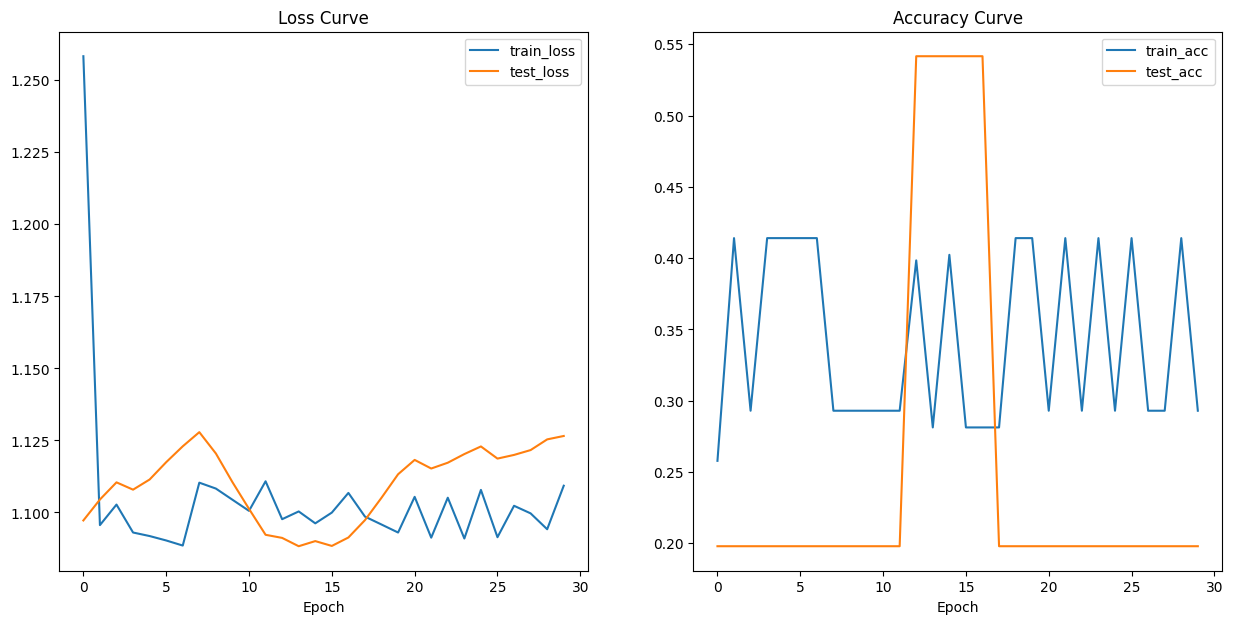

In [27]:
plot_loss_curves(model_0_results)

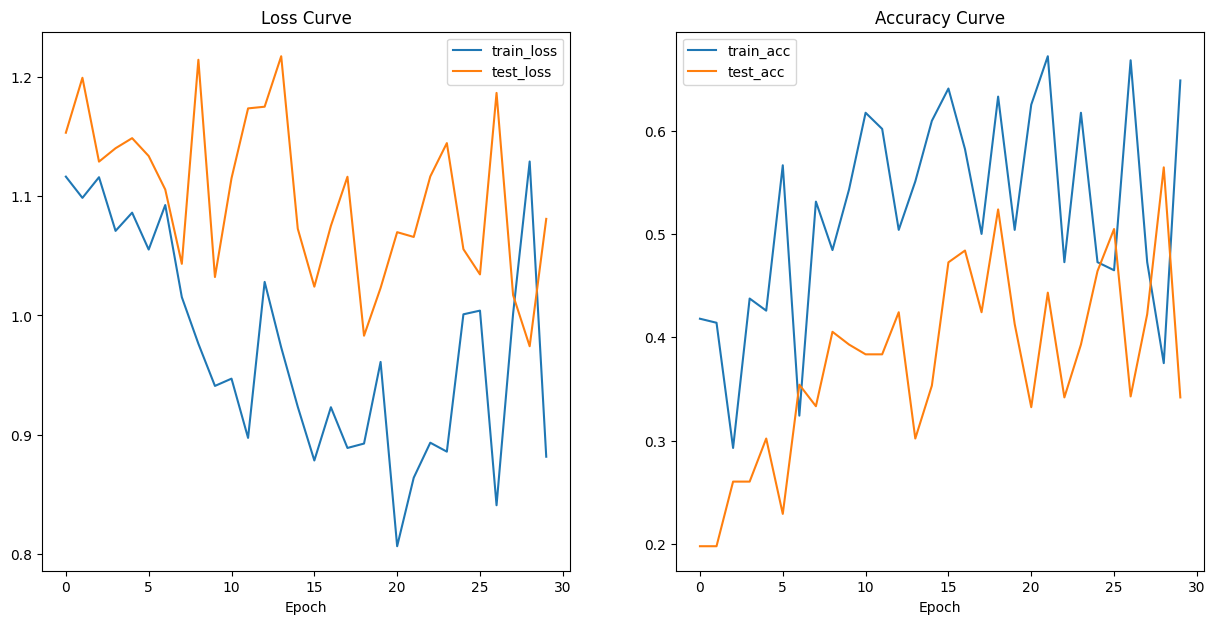

In [28]:
plot_loss_curves(model_1_results)

# 7. Comparing results

In [29]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

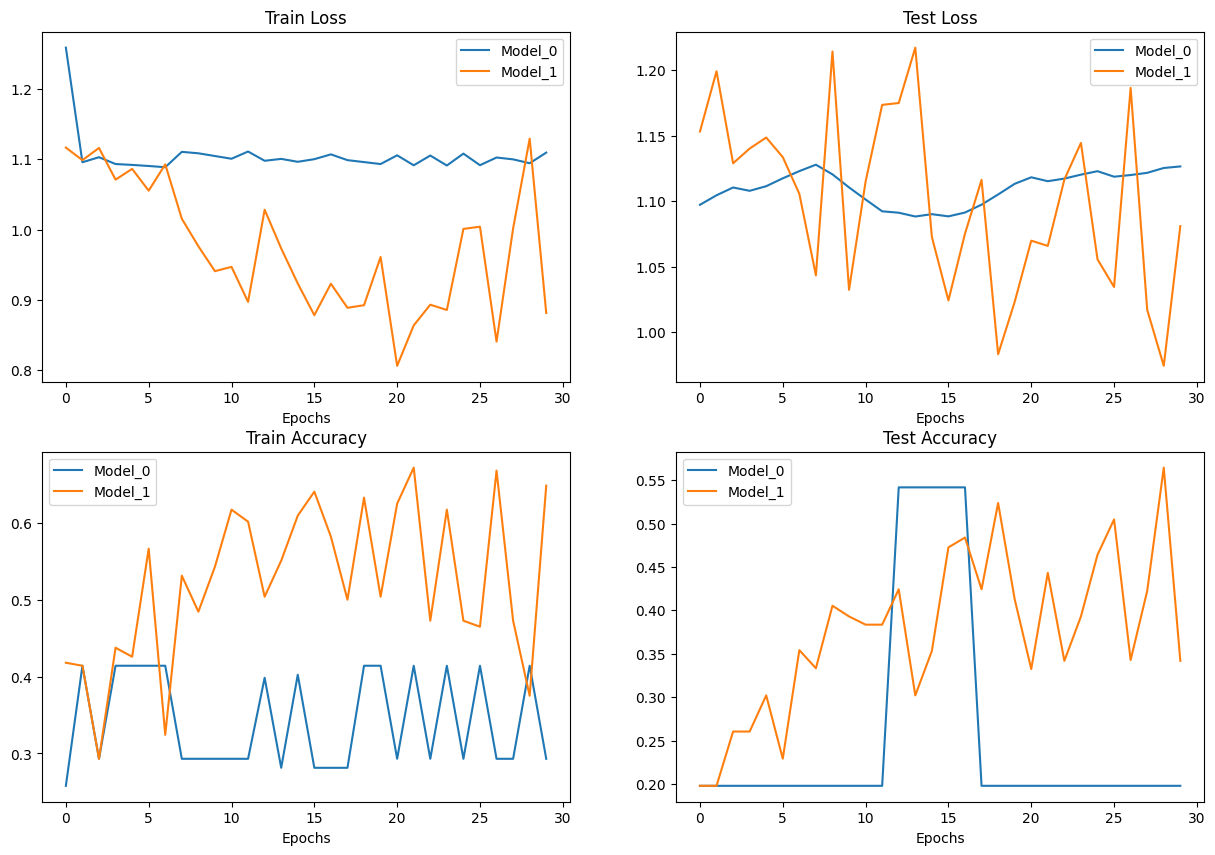

In [30]:
# Setup the plot
plt.figure(figsize = (15, 10))

# Get the number of epochs
epochs = range(len(model_0_df))

# Plot the train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label = "Model_0")
plt.plot(epochs, model_1_df["train_loss"], label = "Model_1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label = "Model_0")
plt.plot(epochs, model_1_df["test_loss"], label = "Model_1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label = "Model_0")
plt.plot(epochs, model_1_df["train_acc"], label = "Model_1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label = "Model_0")
plt.plot(epochs, model_1_df["test_acc"], label = "Model_1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();